In [1]:
#LSTM one-step price as input
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# dummy data
np.random.seed(1)
df = pd.DataFrame(np.random.rand(100, 2), columns=['price', 'sentiment'])
df['price'] = df['price']*100
df.head()

,price,sentiment
0,41.702200,0.720324
1,0.011437,0.302333
2,14.675589,0.092339
3,18.626021,0.345561
4,39.676747,0.538817


In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
values = df.values
values = values.astype('float32') # convert to float
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values) # normalised
reframed = series_to_supervised(scaled, 3, 1)
reframed.drop(reframed.columns[[1,3,5,7]], axis=1, inplace=True) # drop sentiment columns
reframed.head()

,var1(t-3),var1(t-2),var1(t-1),var1(t)
3,0.421653,0.000000,0.148310,0.188264
4,0.000000,0.148310,0.188264,0.401168
5,0.148310,0.188264,0.401168,0.423850
6,0.188264,0.401168,0.423850,0.206664
7,0.401168,0.423850,0.206664,0.027584


In [5]:
# train and test set
split = 0.9
values = reframed.values
train = values[:int(len(values)*split), :]
test = values[int(len(values)*split):, :]
test.shape

(10, 4)

In [6]:
# split into input output
trainX, trainY = train[:, :-1], train[:, -1]
testX, testY = test[:, :-1], test[:, -1]
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

In [7]:
trainX.shape

(87, 1, 3)

In [8]:
# LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]))) # LSTM layer, 100 units
model.add(Dense(1)) # fully connected layer
model.compile(loss='mae', optimizer='adam') # configure training process, mean absolute error

In [9]:
# iterate training batches
history = model.fit(trainX, trainY, epochs=50, batch_size=5, validation_data=(testX, testY), verbose=2, shuffle=False)

Train on 87 samples, validate on 10 samples
Epoch 1/50
 - 1s - loss: 0.4026 - val_loss: 0.3674
Epoch 2/50
 - 0s - loss: 0.3311 - val_loss: 0.2980
Epoch 3/50
 - 0s - loss: 0.3057 - val_loss: 0.2783
Epoch 4/50
 - 0s - loss: 0.3016 - val_loss: 0.2723
Epoch 5/50
 - 0s - loss: 0.3005 - val_loss: 0.2707
Epoch 6/50
 - 0s - loss: 0.2991 - val_loss: 0.2703
Epoch 7/50
 - 0s - loss: 0.2975 - val_loss: 0.2700
Epoch 8/50
 - 0s - loss: 0.2958 - val_loss: 0.2695
Epoch 9/50
 - 0s - loss: 0.2941 - val_loss: 0.2689
Epoch 10/50
 - 0s - loss: 0.2924 - val_loss: 0.2667
Epoch 11/50
 - 0s - loss: 0.2906 - val_loss: 0.2659
Epoch 12/50
 - 0s - loss: 0.2893 - val_loss: 0.2659
Epoch 13/50
 - 0s - loss: 0.2875 - val_loss: 0.2644
Epoch 14/50
 - 0s - loss: 0.2862 - val_loss: 0.2647
Epoch 15/50
 - 0s - loss: 0.2856 - val_loss: 0.2669
Epoch 16/50
 - 0s - loss: 0.2847 - val_loss: 0.2688
Epoch 17/50
 - 0s - loss: 0.2840 - val_loss: 0.2707
Epoch 18/50
 - 0s - loss: 0.2827 - val_loss: 0.2709
Epoch 19/50
 - 0s - loss: 0.2

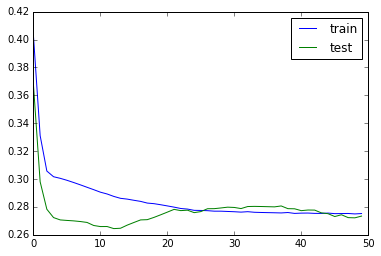

In [10]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()